In [ ]:
from tensorflow.python.keras import layers
import numpy as np
from tensorflow.python.keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
from PIL import Image
import os.path
import warnings
import glob
import os
import zetane
import cv2
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

In [ ]:
def convertjpg(jpgfile,outdir,width=64,height=64):
    img=Image.open(jpgfile)   
    new_img=img.resize((width,height),Image.BILINEAR)   
    new_img.save(os.path.join(outdir,os.path.basename(jpgfile)))
for jpgfile in glob.glob('/root/autodl-tmp/thispersondoesnotexist.10k/*.jpg'):
    convertjpg(jpgfile,'/root/autodl-tmp/thispersondoesnotexist.10k')
for jpgfile in glob.glob('/root/autodl-tmp/0/*.jpg'):
    convertjpg(jpgfile,'/root/autodl-tmp/0')

In [ ]:
def convertjpg_rgba(jpgfile,outdir,width=64,height=64):
    img=Image.open(jpgfile)  
    img = img.convert('RGB')
    new_img=img.resize((width,height),Image.BILINEAR)   
    new_img.save(os.path.join(outdir,os.path.basename(jpgfile)))

In [ ]:
for jpgfile in glob.glob('/root/autodl-tmp/interesting/*.jpg'):
    convertjpg(jpgfile,'/root/autodl-tmp/interesting')

In [ ]:
def getFileName(filepath):
    path_list = []
    pathList = os.listdir(filepath)
    for allFile in pathList:
        everyFile = os.path.join(filepath, allFile)
        path_list.append(everyFile)
    return path_list
training_path = getFileName('/root/autodl-tmp/thispersondoesnotexist.10k')
testing_path = getFileName('/root/autodl-tmp/0')
interesting_path = getFileName('/root/autodl-tmp/interesting')

In [ ]:
training_path = training_path[:10000]

In [ ]:
print(len(training_path))
print(len(testing_path))
print(len(interesting_path))

In [ ]:
testing_img_path = training_path[:800] + testing_path[:200]
training_img_path = training_path[800:]
interesting_path = interesting_path[:3]

In [ ]:
test_y = 800*[0] + 200*[1]
test_y = np.array(test_y)

In [ ]:
train = np.array([cv2.imdecode(np.fromfile(path,dtype=np.uint8),-1)/ 255. for path in training_img_path])
train = train.reshape(9200,64,64,3)
print(train.shape)
test = np.array([cv2.imdecode(np.fromfile(path,dtype=np.uint8),-1)/ 255. for path in testing_img_path])
test = test.reshape(1000,64,64,3)
print(test.shape)
interesting = np.array([cv2.imdecode(np.fromfile(path,dtype=np.uint8),-1)/ 255. for path in interesting_path])
interesting = interesting.reshape(3,64,64,3)
print(interesting.shape)

In [ ]:
import tensorflow.python.keras as keras
from tensorflow.python.keras import layers

input_img = keras.Input(shape=(64, 64, 3))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
conv_shape = tf.shape(x)
x = layers.Flatten()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(8, activation='relu')(x)
encoded = layers.Dense(4, activation='relu')(x)
x = layers.Dense(4, activation='relu')(encoded)
x = layers.Dense(16, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = tf.reshape(x, conv_shape)
x = layers.Conv2D(4, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(x) 
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

In [ ]:
from tensorflow.python.keras.callbacks import TensorBoard

autoencoder.fit(train, train,
                epochs=1000,
                batch_size=128,
                shuffle=True,
                validation_data=(train, train),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

In [ ]:
#autoencoder.save("autoencoder_cartoon_fc.h5")
#autoencoder.save_weights("autoencoder_cartoon_fc_weights.h5")

In [ ]:
from tensorflow import keras
autoencoder = keras.models.load_model('autoencoder_cartoon_fc')
autoencoder.load_weights("autoencoder_cartoon_fc_weights.h5")

In [ ]:
def plot_AE_history(history):
    plt.plot(history.history.history['loss'],
             'b',
             label='Training loss')
    plt.plot(history.history.history['val_loss'],
             'r',
             label='Validation loss')
    plt.legend(loc='lower right')
    plt.xlabel('Epochs')
    plt.ylabel('Loss, [mse]')
    plt.ylim([0.6,0.7])
    plt.show()

plot_AE_history(autoencoder)

In [ ]:
X_pred = autoencoder.predict(train)

In [ ]:
normal_max = 0
loss_list = []
for i in range(train.shape[0]):
    normal_loss = X_pred[i]
    loss = np.mean((normal_loss-train[i])**2)
    normal_max = max(normal_max, loss)
    loss_list.append(loss)

In [ ]:
a = np.linspace(0, 9200, 9200)
plt.scatter(a, np.array(loss_list), s = 3)

In [ ]:
X_test_pred = autoencoder.predict(test)

In [ ]:
X_interesting_pred = autoencoder.predict(interesting)

In [ ]:
losses_int = []
for i in range(interesting.shape[0]):
    interesting_decoded = X_interesting_pred[i]
    loss_int = np.mean((interesting_decoded-interesting[i])**2)
    losses_int.append(loss_int)

In [ ]:
losses_int

In [ ]:
threshold = np.linspace(0, 1, 5000)

In [ ]:
losses = []
for i in range(test.shape[0]):
    x_decoded = X_test_pred[i]
    loss = np.mean((x_decoded-test[i])**2)
    losses.append(loss)

In [ ]:
a = np.linspace(0, 800, 800)
plt.scatter(a, np.array(losses[0:800]), color = 'red', s=3)
b = np.linspace(800, 1000, 200)
plt.scatter(b, np.array(losses[800:]), color = 'blue', s=3)  

In [ ]:
from sklearn.metrics import accuracy_score,f1_score
acc_list = []
f1_list = []
for t in threshold:    
    y_pred = (losses>t).astype(np.int64)
    acc_list.append(accuracy_score(y_pred,test_y))
    f1_list.append(f1_score(y_pred,test_y))

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(threshold,acc_list,c = 'y',label = 'acc')
plt.plot(threshold,f1_list,c = 'b',label = 'f1')
plt.xlabel('threshold')
plt.ylabel('Anomaly Detection score')
plt.legend()

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
i = np.argmax(f1_list)
t = threshold[i]
score = f1_list[i]
print('Recommended threshold: %.3f, related f1 score: %.3f'%(t,score))

y_pred = (losses>t).astype(np.int64)
y_pred = y_pred.reshape(1000,1)
test_y = test_y.reshape(1000,1)
TP = ((test_y==1) & (y_pred==1)).sum()
FN = ((test_y==1) & (y_pred==0)).sum()
FP = ((test_y==0) & (y_pred==1)).sum()
TN = ((test_y==0) & (y_pred==0)).sum()
acc = (TP+TN)/1000
recall = TP/(TP+FN)
precision = TP/(TP+FP)
f1 = 2*precision*recall/(precision+recall)
auc_score = roc_auc_score(test_y,y_pred)
print('In %d data of test set, TP: %d, FN: %d, FP: %d, TN: %d'%(len(test_y),TP,FN,FP,TN))
print('accuracy: %.3f, recall: %.3f, precision: %.3f, related f1 score: %.3f, AUC: %.3f'%(acc,recall,precision,f1, auc_score))

In [ ]:
i = np.argmax(acc_list)
t = threshold[i]
score = acc_list[i]
print('Recommended threshold: %.3f, related acc score: %.3f'%(t,score))

y_pred = (losses>t).astype(np.int64)
y_pred = y_pred.reshape(1000,1)
test_y = test_y.reshape(1000,1)
TP = ((test_y==1) & (y_pred==1)).sum()
FN = ((test_y==1) & (y_pred==0)).sum()
FP = ((test_y==0) & (y_pred==1)).sum()
TN = ((test_y==0) & (y_pred==0)).sum()
acc = (TP+TN)/1000
recall = TP/(TP+FN)
precision = TP/(TP+FP)
f1 = 2*precision*recall/(precision+recall)
auc_score = roc_auc_score(test_y,y_pred)
print('In %d data of test set, TP: %d, FN: %d, FP: %d, TN: %d'%(len(test_y),TP,FN,FP,TN))
print('accuracy: %.3f, recall: %.3f, precision: %.3f, related f1 score: %.3f, AUC: %.3f'%(acc,recall,precision,f1, auc_score))

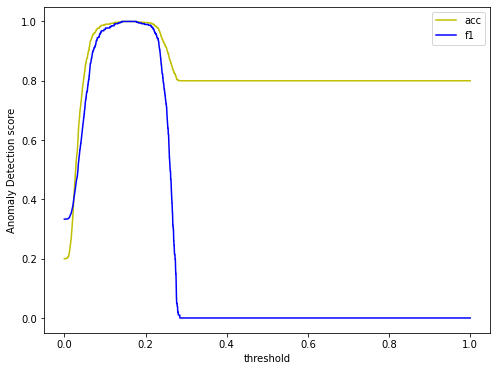

In [27]:
plt.figure(figsize=(8,6))
plt.plot(threshold,acc_list,c = 'y',label = 'acc')
plt.plot(threshold,f1_list,c = 'b',label = 'f1')
plt.xlabel('threshold')
plt.ylabel('Anomaly Detection score')
plt.legend()

In [32]:
from sklearn.metrics import roc_auc_score

In [33]:
i = np.argmax(f1_list)
t = threshold[i]
score = f1_list[i]
print('Recommended threshold: %.3f, related f1 score: %.3f'%(t,score))

y_pred = (losses>t).astype(np.int64)
y_pred = y_pred.reshape(1000,1)
test_y = test_y.reshape(1000,1)
TP = ((test_y==1) & (y_pred==1)).sum()
FN = ((test_y==1) & (y_pred==0)).sum()
FP = ((test_y==0) & (y_pred==1)).sum()
TN = ((test_y==0) & (y_pred==0)).sum()
acc = (TP+TN)/1000
recall = TP/(TP+FN)
precision = TP/(TP+FP)
f1 = 2*precision*recall/(precision+recall)
auc_score = roc_auc_score(test_y,y_pred)
print('In %d data of test set, TP: %d, FN: %d, FP: %d, TN: %d'%(len(test_y),TP,FN,FP,TN))
print('accuracy: %.3f, recall: %.3f, precision: %.3f, related f1 score: %.3f, AUC: %.3f'%(acc,recall,precision,f1, auc_score))

Recommended threshold: 0.142, related f1 score: 1.000
In 1000 data of test set, TP: 200, FN: 0, FP: 0, TN: 800
accuracy: 1.000, recall: 1.000, precision: 1.000, related f1 score: 1.000, AUC: 1.000


In [34]:
i = np.argmax(acc_list)
t = threshold[i]
score = acc_list[i]
print('Recommended threshold: %.3f, related acc score: %.3f'%(t,score))

y_pred = (losses>t).astype(np.int64)
y_pred = y_pred.reshape(1000,1)
test_y = test_y.reshape(1000,1)
TP = ((test_y==1) & (y_pred==1)).sum()
FN = ((test_y==1) & (y_pred==0)).sum()
FP = ((test_y==0) & (y_pred==1)).sum()
TN = ((test_y==0) & (y_pred==0)).sum()
acc = (TP+TN)/1000
recall = TP/(TP+FN)
precision = TP/(TP+FP)
f1 = 2*precision*recall/(precision+recall)
auc_score = roc_auc_score(test_y,y_pred)
print('In %d data of test set, TP: %d, FN: %d, FP: %d, TN: %d'%(len(test_y),TP,FN,FP,TN))
print('accuracy: %.3f, recall: %.3f, precision: %.3f, related f1 score: %.3f, AUC: %.3f'%(acc,recall,precision,f1, auc_score))

Recommended threshold: 0.142, related acc score: 1.000
In 1000 data of test set, TP: 200, FN: 0, FP: 0, TN: 800
accuracy: 1.000, recall: 1.000, precision: 1.000, related f1 score: 1.000, AUC: 1.000
